# Notebook for preparing data for spine labelling

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import csv
%matplotlib inline

In [2]:
sag_path = '/home/donal/PhD/initial_spines/CT_models/data/all_verts/'
coronal_projections_path = '../images_coronal/all_projections/'
sag_projections_path = '../images_sagittal/all_projections/'
data_list = '/home/donal/PhD/initial_spines/CT_models/data_lists/data_list_all_forviewing.txt'

In [3]:
ordered_verts = ['T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'L1', 'L2', 'L3', 'L4']

## Functions for loading/checking data

In [285]:
def get_centre(pts_file):
    """
    Find centre point of vertebral body from sagittal annotations
    """
    with open(pts_file, 'r') as f:
        text = f.readlines()
        lines = [line.strip() for line in text]
        start = lines.index('{')
        end = lines.index('}')
        points = lines[start+1:end]
        top_y = [float(line.split(' ')[-1]) for line in points[0:10]]
        bot_y = [float(line.split(' ')[-1]) for line in points[19:29]]
        top_y.extend(bot_y)
    return np.mean(top_y)

def get_mask(pts_file):
    """
    Get all annotations for every level
    """
    with open(pts_file, 'r') as f:
        text = f.readlines()
        lines = [line.strip() for line in text]
        start = lines.index('{')
        end = lines.index('}')
        x = [float(x.split(' ')[0]) for x in lines[start+1:end]]
        y = [float(x.split(' ')[1]) for x in lines[start+1:end]]
        points = (x, y)
    return points
    
def check_rejects(pts_dict):
    # Check for overlapping annotations
    reject_list = []
    for key, val in pts_dict.items():
        for vert, elem in val.items():
            # Find nearest centre point
            coords = list(val.values())
            coords.remove(elem)
            zipped_coords = list(zip(*coords))
            near_neigh = sorted(
                list(zipped_coords[-1]), key=lambda x: abs(x-elem[-1]))[0]
            # Find distance between centroid for vert and nearest neighbour
            dist = int(abs(elem[-1]-near_neigh))
            if dist == 0:
                print(key, vert)
                reject_list.append(key)
                continue
    return reject_list

def find_x_val(coronal_pts, tgt):
    """
    Find x val in coronal projection by finding coronal midline
    """
    with open(coronal_pts, 'r') as f:
        text = f.readlines()
        lines = [line.strip() for line in text]
        start = lines.index('{')
        end = lines.index('}')
        points = lines[start+1:end]
        y_vals = [float(line.split(' ')[-1]) for line in points]
        x_vals = [float(line.split(' ')[0]) for line in points]
    # Get top 2 closest values to sag. midpoint (y-axis)
    mini = sorted(y_vals, key=lambda t: abs(t-tgt))[:2]
    idx = [y_vals.index(val) for val in mini]
    select_x = np.asarray(x_vals)[idx]
    del_y = mini[0] - mini[1]
    del_x = select_x[0]-select_x[1]
    if del_x == 0:
        return select_x[0]
    else:
        slope = del_y/del_x
        b = mini[0]-slope*select_x[0]
    #y=mx+b => x = (y-b)/m
    return (tgt-b)/slope

def get_id():
    """
    Collect paths to point files, in a dict
    """
    sag_files = [file for file in os.listdir(sag_path)]
    pts_files = {}
    with open(data_list, 'r') as f:
        lines = f.readlines()
        lines = [line.strip() for line in lines]
        start = lines.index('{')
        end = lines.index('}')
        info_list = lines[start+1:end]
        for line in info_list:
            pts, img = line.split(':')
            if '_Sag_' in pts:
                id_ = pts.split('.')[0].split('_Sag_')[0]
            else:
                id_ = pts.split('.')[0].split('_midline_')[0]

            matched_mip = [filename for filename in os.listdir(
                coronal_projections_path) if id_ in filename]
            for file in matched_mip:
                id_ = file.split('.npy')[0]
                vert_list = list(
                    filter(lambda x: f'{id_}_midline' in x, sag_files))
                if not vert_list:
                    continue
                else:
                    pts_files[id_] = vert_list
    return pts_files

def get_points(pts_files):
    """
     Get coordinates of each vertebral centre point
    """
    mask_dict = {} #All landmark annotations for making a mask of vert.
    pts_dict = {}
    for key, val in pts_files.items():
        name = f'{key}_kj'
        if key == '01_06_2014_363_Sag':
            pts_dict[name] = {}
            print(val)
            mask_dict[name] = {}
            for elem in val:
                # Find name of vertebra
                name_split = re.findall('[0-9a-zA-Z][^A-Z]*',
                                        os.path.splitext(elem)[0])
                vert = name_split[-1].split('_')[0]
                # Get y-value of centre-point on saggital
                coronal_filename = f'{name}.jpg.pts'
                centre_point = get_centre(os.path.join(sag_path, elem))

                # Get all landmark point annotations
                points = get_mask(os.path.join(sag_path, elem))
                mask_dict[name][vert] = points
                # Get x-value
                x_val = find_x_val(
                    f'/home/donal/PhD/initial_spines/CT_models/MIP/data/points/{coronal_filename}', centre_point)
                pts_dict[name][vert] = (x_val, centre_point)

    return pts_dict, mask_dict

## Collect Points 

In [286]:
pts_files = get_id()
print(f'Found {len(list(pts_files.keys()))} points files w/ matching MIP')
pts_dict, mask_dict = get_points(pts_files)
print(f'Found {len(list(pts_dict.keys()))} vertebral annotations.')
print(f'Found {len(list(mask_dict.keys()))} full vert. annotations.')


Found 353 points files w/ matching MIP
['01_06_2014_363_Sag_midline_ij_5mm_flop_T12_ns.pts', '01_06_2014_363_Sag_midline_ij_5mm_flop_L1_ns.pts', '01_06_2014_363_Sag_midline_ij_5mm_flop_L2_ns.pts', '01_06_2014_363_Sag_midline_ij_5mm_flop_T10_ns.pts', '01_06_2014_363_Sag_midline_ij_5mm_flop_T11_ns.pts', '01_06_2014_363_Sag_midline_ij_5mm_flop_L3_ns.pts', '01_06_2014_363_Sag_midline_ij_5mm_flop_L4_ns.pts', '01_06_2014_363_Sag_midline_ij_5mm_flop_T9_ns.pts']
Found 1 vertebral annotations.
Found 1 full vert. annotations.


## TEST

In [6]:
import nibabel as nib
from scipy import optimize, interpolate
import SimpleITK as sitk
from ast import literal_eval
from PIL import Image

In [7]:
pts_df = pd.DataFrame(pts_dict, columns=list(pts_dict.keys()), index=ordered_verts)
#pts_df.T.to_csv('../formatted_pts.csv', index=True, columns=ordered_verts)

In [8]:
df = pd.read_csv('../formatted_pts.csv', names=ordered_verts, header=0)
df.head()

,T4,T5,T6,T7,T8,T9,T10,T11,T12,L1,L2,L3,L4
01_06_2014_363_Sag_kj,NaN,NaN,NaN,NaN,NaN,"(194.541, 32.824456035)","(194.541, 60.339832195)","(194.541, 90.35260330499999)","(193.05578799440178, 122.43826534999998)","(192.688, 155.9578523)","(191.68579431542975, 191.87922805)","(190.85535257102617, 227.53173525000003)","(192.98159826293391, 264.78959645)"
01_06_2014_364_Sag_kj,NaN,NaN,NaN,NaN,NaN,"(210.9350837886782, 26.707615209999993)","(210.52701635353554, 55.420611654999995)","(211.04822490292688, 86.65450268999999)","(210.517102422304, 119.11843819999999)","(209.97770073458233, 154.35197655000002)","(207.849475923657, 192.29074359999998)","(207.26024566414364, 231.37322039999995)","(203.55681961424594, 271.00911245)"
01_06_2014_365_Sag_kj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(238.6875023161938, 47.95229659)","(239.25541131009095, 88.33418433)","(240.37422485213688, 132.13715085)","(236.44231906384135, 178.36627)","(233.787, 223.83646725000003)"
01_06_2014_366_Sag_kj,NaN,NaN,NaN,NaN,"(195.40735464456014, 37.798548575000005)","(194.8536543614951, 64.94493367)","(193.23180570667446, 93.59655483999998)","(192.23975751040615, 124.09215309999999)","(190.76590774833215, 156.0011131)","(188.65421979099744, 191.25575895)","(187.30783747421634, 227.89500285)","(185.52545307555994, 267.69570809999993)","(184.46788088218705, 307.9037234)"
01_06_2014_367_Sag_kj,NaN,NaN,NaN,NaN,"(218.239, 32.57485491)","(218.18917983489766, 59.080277375)","(217.75987458541348, 87.691459175)","(217.98418089295149, 119.26005024999999)","(216.84208725132524, 151.03624315)","(215.39087695973674, 185.52968329999996)","(214.80735416315918, 223.59064029999996)","(213.796, 262.1483133500001)","(213.796, 302.2372402)"


In [282]:
df.loc['01_06_2014_363_Sag_kj']

T4                                          NaN
T5                                          NaN
T6                                          NaN
T7                                          NaN
T8                                          NaN
T9                      (194.541, 32.824456035)
T10                     (194.541, 60.339832195)
T11                (194.541, 90.35260330499999)
T12    (193.05578799440178, 122.43826534999998)
L1                       (192.688, 155.9578523)
L2           (191.68579431542975, 191.87922805)
L3     (190.85535257102617, 227.53173525000003)
L4           (192.98159826293391, 264.78959645)
Name: 01_06_2014_363_Sag_kj, dtype: object

In [9]:
direct_df = pd.read_csv('../dicom_direction.csv', index_col='Name', converters={'Direction': literal_eval, 'Origin': literal_eval})
direct_df.head()

,Direction,Origin
Name,,
03_06_2014_389_Sag,"(0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0)","(201.6633148, -353.9631348, 131.249939)"
03_06_2014_402_Sag,"(0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0)","(173.4781189, -159.1593781, 98.0)"
03_06_2014_396_Sag,"(0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0)","(203.453125, -223.1618958, 57.64001465)"
03_06_2014_395_Sag,"(-0.3499322470372717, 0.0, -0.9367750116668602...","(190.7415924, -124.9147186, 81.60995483)"
03_06_2014_399_TS_Sag,"(0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0)","(165.7218781, -164.1593781, 122.75)"


In [255]:
def pad_image(img, output_shape=(512, 512)):
    """
    Insert into array of fixed size - such that all inputs to model have same dimensions
    """
    padding = [(s-x)//2.0 for x, s in zip(output_shape, img.GetSize())]
    output_origin = img.TransformContinuousIndexToPhysicalPoint(padding)
    pad = sitk.ResampleImageFilter()
    pad.SetInterpolator(sitk.sitkLinear)
    pad.SetDefaultPixelValue(-1024)
    pad.SetOutputSpacing(img.GetSpacing())
    pad.SetSize(output_shape)
    pad.SetOutputOrigin(output_origin)
    #pad.SetOutputDirection(img.GetDirection())
    pad.SetOutputDirection(base_direction)
    return pad.Execute(img), padding

def normalize(img, min=0, max=255):
    """
    Cast float image to int, and normalise to [0, 255]
    """
    img = sitk.Cast(img, sitk.sitkInt32)
    norm = sitk.RescaleIntensityImageFilter()
    norm.SetOutputMaximum(max)
    norm.SetOutputMinimum(min)
    return norm.Execute(img)

def resample(image, new_spacing, output_shape=(512, 512, 512)):
    """
    Resample image to new resolution with pixel dims defined by new_spacing
    """
    # Calculate image size
    orig_size = np.array(image.GetSize(), dtype=np.int)
    orig_spacing = image.GetSpacing()
    ratio = [x/y for x, y in zip(orig_spacing, new_spacing)]
    new_size = orig_size*ratio
    new_size = np.ceil(new_size).astype(np.int)
    new_size = [int(s) for s in new_size]

    # Prepare filter
    resample = sitk.ResampleImageFilter()
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetDefaultPixelValue(-1024)
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(image.GetOrigin())
    resample.SetOutputSpacing(new_spacing)
    resample.SetSize(new_size)
    #resample.SetTransform(transform)
    res_img = resample.Execute(image)
    
    
    # Define transformation
    transform = sitk.AffineTransform(3)
    #transform.SetTranslation(-np.array(image.GetOrigin()))
    transform.SetCenter(res_img.TransformContinuousIndexToPhysicalPoint(np.array(res_img.GetSize())/2.0))
    
    matrix = np.array(transform.GetMatrix()).reshape((3, 3))
    # Get rotation angles in radians
    # !! TODO - Needs to vary according to image!)
    rad_x = 0
    rad_y = np.pi/2
    rad_z = 0
    # Define cosine matrix
    R_x = np.array([[0, np.cos(rad_x), -np.sin(rad_x)],
                    [1, 0, 0],
                    [0, np.sin(rad_x), np.cos(rad_x)]])
    
    R_y = np.array([[np.cos(rad_y), 0, np.sin(rad_y)],
                    [-np.sin(rad_y), 0, np.cos(rad_y)],
                    [0, 1, 0]])
     
    R_z = np.array([[0, 0, 1], 
                    [np.cos(rad_z), -np.sin(rad_z), 0],
                    [np.sin(rad_z), np.cos(rad_z), 0]])
    
    new_matrix = np.dot(R_z, matrix)
    new_matrix = np.dot(R_y, new_matrix)
    new_matrix = np.dot(R_x, new_matrix)
    transform.SetMatrix(new_matrix.ravel())  
    
    padding = [(s-x)//2 for x, s in zip(output_shape, res_img.GetSize())]
    output_origin = res_img.TransformContinuousIndexToPhysicalPoint(padding)
    
    
    pad = sitk.ResampleImageFilter()
    pad.SetInterpolator(sitk.sitkLinear)
    pad.SetDefaultPixelValue(-1024)
    pad.SetOutputSpacing(res_img.GetSpacing())
    pad.SetOutputDirection(res_img.GetDirection())
    pad.SetSize(output_shape)
    pad.SetOutputOrigin(output_origin)
    pad.SetTransform(transform)
    
    return pad.Execute(res_img), res_img, ratio, padding

In [25]:
def get_ROI(img, fit, width=4):
    roi = np.zeros((512, 2*width, 512))
    roi -= 1024
    for i, y in enumerate(fit):
        sample = img[i, int(y)-width:int(y)+width]
        roi[i] = sample
    return roi

def plot_midline(name, mip, scaling, padding, orig_scale, plot=False):
    img = Image.open(f'/home/donal/PhD/initial_spines/CT_models/MIP/data/images/{name}_kj.tiff')
    img = np.array(img)
    # --- Load coordinates and transform to frame ---
    og_x, og_y = zip(*[literal_eval(x) for x in df.loc[f'{name}_kj'].dropna().values])
    x = np.array(og_x, dtype=float)
    x *= min(orig_scale) 
    x /= 4*0.3125
    x -= padding[2]
    y = np.array(og_y, dtype=float)
    y *= min(orig_scale)
    y /= 4*0.3125
    y -= padding[1]
    # --- FIT 1st order spline ---
    tck = interpolate.splrep(og_y, og_x, k=1, s=0)
    xd = np.linspace(0, 512, 512)
    fit = interpolate.splev(xd, tck, der=0)
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(20, 10))
        ax[0].imshow(img, cmap='gray')
        sns.scatterplot(x=og_x, y=og_y, color='y', s=45, edgecolor='k', ax=ax[0])
        ax[0].plot(fit, xd, linewidth=1.5, color='r')
        ax[0].set_ylim([512, 0])
        # My attempt
        ax[1].imshow(mip, cmap='gray')
        sns.scatterplot(x=x, y=y, color='y', s=45, edgecolor='k', ax=ax[1])
    return fit

In [12]:
def get_orig_pix(name):
    pix_info = f'/home/donal/CT_volumes/resampled_mip/pixels/{name}_mip_WL.txt'
    with open(pix_info, 'r') as f:
        text = f.readlines()
        x, y, z = (float(x) for x in text[1].split(' '))
    return (x, y, z)

def resample_data(name, data):
    # Resample Image
    min_pix = 4*0.3125
    pad_img, res_img, scaling, padding = resample(data, (min_pix, min_pix, min_pix))
    return pad_img, res_img, scaling, padding

In [280]:
#name = '03_06_2014_389_Sag'
def get_sagittal_midline(name, plot=False):
    # ---- READ VOLUME -- 
    orig_direction = direct_df.loc[name].values[0]
    orig_origin = direct_df.loc[name].values[1]
    reader = sitk.ImageFileReader()
    reader.SetImageIO("NiftiImageIO")
    reader.SetFileName(f'../ct_volumes/{name}.nii')
    data = reader.Execute()
    print(orig_direction)
    data.SetDirection(orig_direction)
    data.SetOrigin(orig_origin)
    print(data.GetDirection())
    print(data.GetOrigin())
    
    
#     # ---- Norm. coordinates --- 
    image_out = sitk.GetImageFromArray(sitk.GetArrayFromImage(data))
    #setup other image characteristics
    image_out.SetOrigin(data.GetOrigin())
    image_out.SetSpacing(data.GetSpacing())
    #set to RAI
    #image_out.SetDirection(base_direction)
    image_out.SetDirection(data.GetDirection())
    
    orig_scale= data.GetSpacing()
    
    # --- REFORMAT DATA ---
    pad_img, res_img, scale, padding = resample_data(name, image_out)
#     pad_img, padding = pad_image(res_img, output_shape=(512, 512, 512))
    pad_img = sitk.GetArrayFromImage(pad_img)
    
    # ----Coronal MIP ---
    #clipped = np.clip(sitk.GetArrayFromImage(res_img), a_min=-100, a_max=900)
    clipped = np.clip(pad_img, a_min=-100, a_max=900)
    mip = np.max(clipped, axis=-1)
    
    # Get Fit from points
    fit = plot_midline(name, np.fliplr(mip), scale, padding, orig_scale, plot=True)
    
    if plot:
#         fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#         ax.imshow(res_img[:, 150, :])
        pass
    
    
    # Get ROI around fit
    """
    
    roi = get_ROI(pad_img, fit)
    print('ROI', roi.shape)
    roi = np.clip(roi, a_min=-100, a_max=500)
    arr = np.max(roi, axis=0)

    arr = sitk.GetImageFromArray(arr)
    arr.SetSpacing(get_orig_pix(name))
    # Normalise array
    arr_norm = normalize(arr)
    pad_img, padding = pad_image(arr_norm, output_shape=(512, 512))
    
    norm_img = sitk.GetArrayFromImage(pad_img)
    print(norm_img.shape)
    #np.save(f'../data/sag_midline/{name}.npy', norm_img)
    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(norm_img, cmap='gray')
#         fig.savefig(f'../images_sagittal/midline/{name}.png')
#         plt.close()
"""

01_06_2014_363_Sag_kj
(0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0)
(-0.0, 0.0, -1.0, 1.0, -0.0, 0.0, 0.0, -1.0, 0.0)
(185.390625, -237.4031219, 122.9999695)
(0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0)
(-0.0, 0.0, -1.0, 1.0, -0.0, 0.0, 0.0, -1.0, 0.0)
(183.5497, -224.17059, 1625.17346)


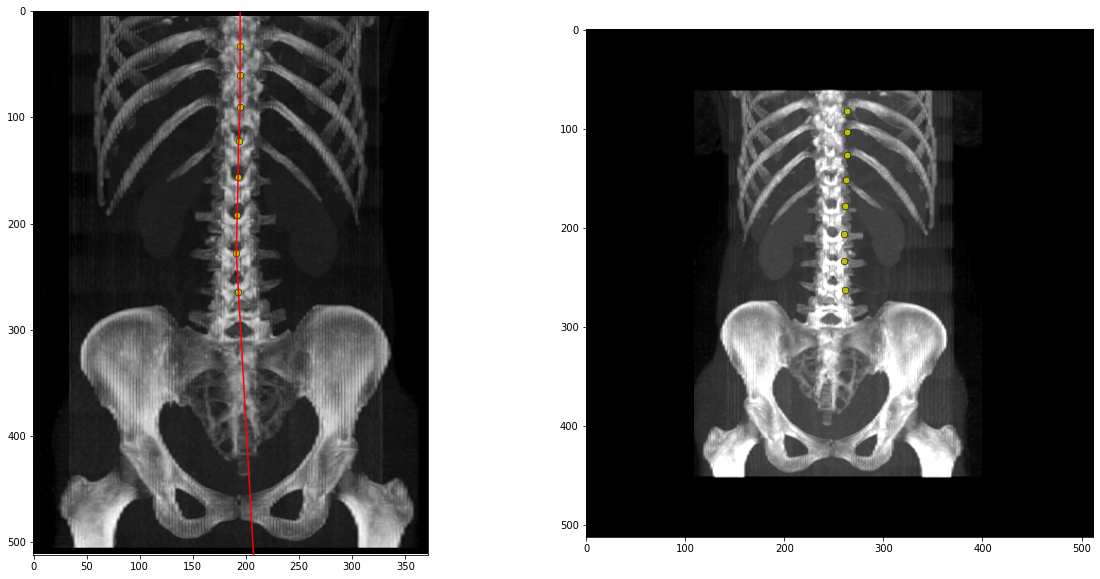

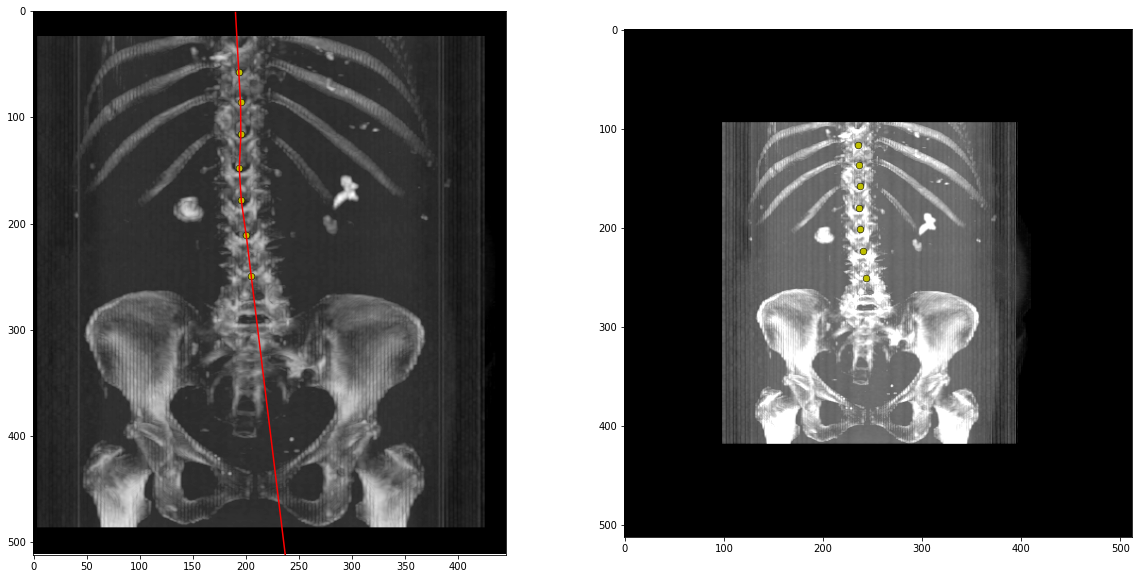

In [281]:
base_direction = (0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0)
base_origin = (0.0, 0.0, 0.0)
for name in df.index:
    #if direct_df.loc[name.strip('_kj')].values[0] != base_direction:
    if name  == '01_06_2014_363_Sag_kj':
        print(name)
        get_sagittal_midline(name.strip('_kj'), plot=True)
        
    elif name == 'fr_555_LS_Sag_kj':
        get_sagittal_midline(name.strip('_kj'), plot=True)
        break

## Convert to one-hot encoding

In [15]:
from sklearn.preprocessing import LabelBinarizer

In [16]:
 vert_list = []
# Convert vertebra names to one-hot
for val in pts_dict.values():
    vert_list.extend(list(val.keys()))
all_verts = list(np.unique(vert_list))
enc = LabelBinarizer()
enc.fit(all_verts)
enc.classes_ = ordered_verts
# Check for overlapping annotations
reject_list = set(check_rejects(pts_dict))
# Add key to rejects -- Some issue with the formatting annotations were off the image
reject_list.add('23_05_2014_153_Sag')
print(f'Found {len(reject_list)} rejects.')

Found 1 rejects.


## Read pixel info, collected when MIPs were performed

In [17]:
 # Read pixel info
pix_info = pd.read_csv(
    '/home/donal/CT_volumes/pixel_size.csv', index_col='Name')
min_pix = pix_info.loc[:, 'Size (mm)'].min()
print(f'Minimum pixel size across dataset: {min_pix} mm')
print(pix_info.head())

Minimum pixel size across dataset: 0.3125 mm
                                              Size (mm)
Name                                                   
18_03_2015_20150318152008968_SRS00000_mip_WL   0.685000
fr_580_LS_Sag_mip_WL                           0.781250
29_05_2014_60_Sag_mip_WL                       0.781250
fr_560_TS_Sag_mip_WL                           0.701172
06_06_2014_502_LS_Sag_mip_WL                   0.800000


# Prepare images

In [18]:
import scipy.stats as stats
from scipy.special import softmax
from scipy.spatial import ConvexHull, Delaunay
from matplotlib.path import Path
from PIL import Image, ImageDraw
import nibabel as nib
from scipy.ndimage import gaussian_filter

In [19]:
midline_path = '../data/sag_midline/'

In [20]:
def prep_images(pts_dict, mask_dict, rejects, pix_info, outpath='./data/annotated_sanity/', plot=False):
    # Prepare data for Train/Test/Val split
    cor_info_csv = '../images_coronal/annotation_info.csv'
    sag_info_csv = '../images_sagittal/annotation_info.csv'
    clean_path = '/home/donal/PhD/initial_spines/CT_models/FCN/data/clean_data.npz'
    volume_path = './ct_volumes/'
    clean_data = np.load(clean_path)
    id_list = [''.join(elem) for elem in clean_data['id']]
    cor_info = pd.read_csv(cor_info_csv)
    sag_info = pd.read_csv(sag_info_csv)
    for key, val in pts_dict.items():
        print(key)
        if key.split('_kj')[0] not in rejects:
            key = key.split('_kj')[0]
            # Check if ID is in clean_data (i.e annotation is ok)
            if key not in id_list:
                print('Issue with image, skipping...')
                continue
            out_img_path = os.path.join(outpath, f'{key}_annotated.tiff')
            # Load projection images
            cor_filename = os.path.join(coronal_projections_path, f'{key}.npy')
            cor_img = np.load(cor_filename)
            sag_filename = os.path.join(sag_projections_path, f'{key}.npy')
            sag_img = np.load(sag_filename)
            sag_midline = np.load(midline_path + f'{key}.npy')

            # Get info from pre-processing images
            cor = cor_info.loc[cor_info['Name'] == key]
            cor_pad = literal_eval(cor.iloc[0]['Padding'])
            cor_scale = literal_eval(cor.iloc[0]['Pixel Scaling'])
            
            sag = sag_info.loc[sag_info['Name'] == key]
            sag_pad = literal_eval(sag.iloc[0]['Padding'])
            sag_scale = literal_eval(sag.iloc[0]['Pixel Scaling'])
            
            # Load vert annotations
            vert_dict = {}
            annot_dict = {}
            for vert, elem in val.items():
                # Account for resampling to isotropic grid
                x, y = (x*s for x, s in zip(elem, sag_scale))
                y -= cor_pad[1]
                x -= cor_pad[0]
                vert_dict[vert] = (x, y)
                
                # Update vert. annotations
                points = mask_dict[f'{key}_kj'][vert]
                
                x = [(x*sag_scale[0])-sag_pad[0] for x in reversed(points[0])]
                y = [(x*sag_scale[1])-sag_pad[1] for x in reversed(points[1])]
                form_points = np.column_stack((x, y))
    
                annot_dict[vert] = form_points
                
            
            # Convert y coordinate to heatmap
            gt_holder = np.zeros((*cor_img.shape[:2], len(ordered_verts)), dtype=np.float32)
            mask_holder = np.zeros((*cor_img.shape[:2], len(ordered_verts)+1), dtype=np.int16)
            midline_holder = np.zeros((*cor_img.shape[:2], 1), dtype=np.float32)
            for vert, (x_coord, y_coord) in vert_dict.items():
                channel = ordered_verts.index(vert)
                # 1D Gaussian for labelling
                x = np.linspace(0, 512, 512)
                gauss = np.array(stats.norm.pdf(x, y_coord, 10))[..., np.newaxis]
                norm_gauss = gauss
                tmp = np.tile(norm_gauss, (1, 512)).astype(np.float32)
                gt_holder[..., channel] = tmp
                
                #2D Gaussian for midline
                midline_holder[int(y_coord), int(x_coord)] = 250
                
                # Convert landmark point annotations to mask (via. ConvexHull)
                points = annot_dict[vert]
                hull = ConvexHull(points)
                indices = hull.vertices
                hull_points = [(x, y) for x, y in points[indices, :]]
                img = Image.new('I', (512, 512), 0)
                
                ImageDraw.Draw(img).polygon(hull_points, outline=1, fill=1)
                mask = np.array(img)
                
                mask_holder[..., channel+1] = np.flip(mask, axis=1)
                
            midline_holder = np.flip(gaussian_filter(midline_holder, sigma=5), axis=1)
            print(midline_holder.max())
            midline_holder = np.where(midline_holder < 0.5, 0.0, 1.0).astype(np.int16)
            print(midline_holder.dtype)
            # Save heatmap to folder
            np.save(f'../data/heatmaps/{key}.npy', gt_holder)
            np.save(f'../data/masks/{key}.npy', mask_holder)
            np.save(f'../data/cor_mid_mask/{key}.npy', midline_holder)
            
            #Get three channel mip only for midline 
            three_chan_mip = np.repeat(cor_img[..., 0][:, :, np.newaxis], 3, axis=2)
            print(three_chan_mip.shape)
            
            #np.save(f'../midline_data/coronal_mips/{key}.npy', three_chan_mip)
            
            print(mask_holder.shape)
            with open(f'../data/coordinates/{key}.csv', 'w') as f:
                wrt = csv.writer(f, dialect='excel')
                wrt.writerow(['Level', 'Coordinate'])
                for vert, (x, y) in vert_dict.items():
                    wrt.writerow([vert, y])
            
            with open(f'../midline_data/coordinates/{key}.csv', 'w') as f:
                wrt = csv.writer(f, dialect='excel')
                wrt.writerow(['Level', 'X', 'Y'])
                for vert, (x, y) in vert_dict.items():
                    wrt.writerow([vert, x, y])
            
            
            mid_composite = sag_img.copy()
            # 0: MIP; 1:AVG ; 2:STD
            mid_composite[..., 1] = sag_midline/255
            np.save(f'../images_sagittal/midline_composite/{key}.npy', mid_composite)
            if plot:
                x = np.linspace(0, 512, num=512)
                fig, axes = plt.subplots(2, 2, figsize=(20, 20))
                ax = axes.ravel()
                ax[0].axis('off')
                ax[1].axis('off')
                #ax[2].axis('off')
                ax[3].axis('off')
                plt.tight_layout()
                ax[2].imshow(cor_img[..., 0], cmap='gray')
                ax[3].imshow(cor_img)
                ax[2].imshow(np.where(midline_holder==0, np.nan, 1), alpha=1)
                ax[1].imshow(np.flip(sag_midline, axis=1), cmap='gray')
                ax[0].imshow(mid_composite)
                ax[3].imshow(sag_img)
                max_ = np.where(np.max(mask_holder, axis=-1)==0, np.nan, 1)
                #ax[0].imshow(max_, alpha=0.5, cmap='winter')
                ax[3].imshow(gt_holder[..., 12], alpha=0.5)
                #ax[3].imshow(np.argmax(mask_holder, axis=-1), alpha=0.5)
                for vert, (x, y) in vert_dict.items():
                    ax[0].axhline(y, linewidth=2, c='y')
                    ax[0].text(0, y-5, vert, color='w')
                    ax[1].axhline(y, linewidth=2, c='y')
                    ax[1].text(0, y-5, vert, color='w')
                    #ax[1].plot(annot_dict[vert][:, 0], annot_dict[vert][:, 1], lw=4, c='w')
                    
                    hull = ConvexHull(annot_dict[vert])
                    hull_indices = hull.vertices
                    # These are the actual points.
                    hull_pts = annot_dict[vert][hull_indices, :]
                    g = ax[1].fill(hull_pts[:,0], hull_pts[:,1], fill=True, edgecolor='w')
                    channel = ordered_verts.index(vert)
                    heatmap = gt_holder[..., channel]

                break



In [ ]:
prep_images(pts_dict, mask_dict, reject_list, pix_info, plot=False)

01_06_2014_363_Sag_kj
1.5916771
int16
(512, 512, 3)
(512, 512, 14)
01_06_2014_364_Sag_kj
1.5916771
int16
(512, 512, 3)
(512, 512, 14)
01_06_2014_365_Sag_kj
1.5916771
int16
(512, 512, 3)
(512, 512, 14)
01_06_2014_366_Sag_kj
1.5916771
int16
(512, 512, 3)
(512, 512, 14)
01_06_2014_367_Sag_kj
1.592211
int16
(512, 512, 3)
(512, 512, 14)
01_06_2014_368_Sag_kj
1.5916771
int16
(512, 512, 3)
(512, 512, 14)
02_06_2014_372_Sag_kj
1.5916771
int16
(512, 512, 3)
(512, 512, 14)
02_06_2014_373_Sag_kj
1.592842
int16
(512, 512, 3)
(512, 512, 14)
02_06_2014_376_LS_Sag_kj
1.5916771
int16
(512, 512, 3)
(512, 512, 14)
02_06_2014_378_Sag_kj
1.5916771
int16
(512, 512, 3)
(512, 512, 14)
02_06_2014_379_Sag_kj
1.5916771
int16
(512, 512, 3)
(512, 512, 14)
02_06_2014_380_Sag_kj
1.6007537
int16
(512, 512, 3)
(512, 512, 14)
02_06_2014_381_Sag_kj
1.6059169
int16
(512, 512, 3)
(512, 512, 14)
02_06_2014_383_LS_Sag_kj
1.5916771
int16
(512, 512, 3)
(512, 512, 14)
02_06_2014_383_TS_Sag_kj
1.5989863
int16
(512, 512, 3)
(51